In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#!ls /content/gdrive

Mounted at /content/drive


In [3]:
# configuration
path = "/content/drive/MyDrive/Colab Notebooks/Project_REScipe/training/"

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from scipy.spatial.distance import cosine

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import PIL
from PIL import Image

if torch.cuda.is_available():
  print(torch.cuda.is_available())
  torch.set_default_tensor_type(torch.cuda.FloatTensor)

True


===================== A =====================

Load train and valid dataset from pickle files into panda dataframe.

In [ ]:
# training vgg
pd.set_option('display.max_columns', None)

t0 = pd.read_pickle(path + "vgg_train_dataframe0.plk")
print('# images in df0:', len(t0))
t1 = pd.read_pickle(path + "vgg_train_dataframe1.plk")
print('# images in df1:', len(t1))
t2 = pd.read_pickle(path + "vgg_train_dataframe2.plk")
print('# images in df2:', len(t2))
t3 = pd.read_pickle(path + "vgg_train_dataframe3.plk")
print('# images in df3:', len(t3), end='\n\n')

train_dataframe = pd.concat([t0,t1,t2,t3], ignore_index=True)
train_dataframe = train_dataframe.drop(columns=['code'])
print('dataframe shape:', train_dataframe.shape, end='\n\n')

print('MLP input shape:', (train_dataframe.iloc[0][0]).shape)
print('MLP output shape:', (train_dataframe.iloc[0][1]).shape)

In [ ]:
# validation vgg
t0 = pd.read_pickle(path + "vgg_val_dataframe0.plk")
print('# images in df0:', len(t0))
t1 = pd.read_pickle(path + "vgg_val_dataframe1.plk")
print('# images in df1:', len(t1))
t2 = pd.read_pickle(path + "vgg_val_dataframe2.plk")
print('# images in df2:', len(t2))
t3 = pd.read_pickle(path + "vgg_val_dataframe3.plk")
print('# images in df3:', len(t3))

valid_dataframe = pd.concat([t0,t1,t2,t3], ignore_index=True)
valid_dataframe = valid_dataframe.drop(columns=['code'])
print('dataframe shape:', valid_dataframe.shape, end='\n\n')

print('MLP input shape:', (valid_dataframe.iloc[0][0]).shape)
print('MLP output shape:', (valid_dataframe.iloc[0][1]).shape)

===================== B =====================

Check similarity between MLP inputs from outputs of VGG.

In [ ]:
## This doesn't work, it assume we have 300 distinct labels but apparently that isnt the case
# print(len(valid_dataframe["label"].values))
# label_classes = []
# def arreqclose_in_list(myarr, list_arrays):
#     return next((True for elem in list_arrays if elem.size == myarr.size and np.allclose(elem, myarr)), False)

# for i in range(len(valid_dataframe["label"].values)):
#   check = arreqclose_in_list(valid_dataframe["label"].values[i], label_classes)
#   if not(check):
#     label_classes.append(valid_dataframe["label"].values[i])
#     print(i,len(label_classes))
#   if i % 1000 == 0:
#     print(i)

## Cosine Similarity Test for first two set of similar images (5 images in each set)
print(valid_dataframe.columns, end='\n\n')
print('cos_similarity', 'e_distance', 'index (cmp with next)', sep='\t')
for i in range(10):
  point1 = valid_dataframe["vgg_features"].values[i]
  point2 = valid_dataframe["vgg_features"].values[i+1]
  sim = cosine_similarity(point1,point2)
  dist = np.linalg.norm(point1 - point2) 
  if i % 5 == 0:
    print('group', i//5, ':')
  print(sim, dist, i, sep='\t')

===================== C =====================

Load test dataset from pickle files into panda dataframe.

In [ ]:
t = pd.read_pickle(path + "vgg_test_dataframe.plk")
print('# images in df:', len(t))
print(t, end='\n')

test_dataframe = pd.concat([t], ignore_index=True)
test_dataframe = test_dataframe.drop(columns=['code'])
print('dataframe shape:', test_dataframe.shape, end='\n\n')

print('MLP input shape:', (test_dataframe.iloc[0][0]).shape)
print('MLP output shape:', (test_dataframe.iloc[0][1]).shape)

===================== D =====================

Define PyTorch dataset with this dataset.

In [5]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    if torch.is_tensor(index):
      index = index.tolist()
    X = self.X[index]
    y = self.y[index]
    return X,y

===================== E =====================

Other helper functions:

(1) printing plots

(2) evaluating model

(3) accuracy function

In [12]:
# printing plot
def plot_result(x=None, y=[], title=[], x_axis="", y_axis="", plot_title=""):
  plt.figure()
  i = 0
  for accu in y:
    plt.plot(x, accu, label=title[i])
    i += 1
  plt.legend(loc='best')
  plt.xlabel(x_axis)
  plt.ylabel(y_axis)
  plt.title(plot_title)
  plt.ylim(0)
  plt.show()

# evaluating a model (model, loss function, valid/test dataloader)
def evaluate(model, loss_fnc, val_iter):
  model.eval()

  running_loss = 0.0
  running_correct = 0.0
  count = 0.0
  for data in val_iter:
    X, y = data
    ## ===================== CUDA version
    # For VGG:
    X = torch.squeeze(X,1)
    X = X.type(torch.cuda.FloatTensor)
    y = y.type(torch.cuda.FloatTensor)
    ## =====================
    output = model(X)
    loss = loss_fnc(output, y)
    running_loss += loss.item() * len(y)
    running_correct += accurate(output, y)
    count += len(y)
  return running_correct/count, running_loss/count

# accuracy function: return number of "correct" prediction
def accurate(pred, label):
  correct = 0
  for i in range(pred.shape[0]): # get the length, maybe use len
    f = pred[i].cpu().detach().numpy().reshape(1,-1)
    l = label[i].cpu().detach().numpy().reshape(1,-1)
    similarity = cosine_similarity(f,l)
    if similarity > 0.9:
      correct += 1
  return correct

===================== F =====================

VGG MLP model and training setup (hyperparameters):

In [16]:
# vgg model
class VGGMLP(nn.Module):
  def __init__(self):
    super(VGGMLP, self).__init__()
    # in-size 4096
    self.bn0 = nn.BatchNorm1d(4096)
    self.fc1 = nn.Linear(4096, 1024)
    self.bn1 = nn.BatchNorm1d(1024)
    self.rl1 = nn.LeakyReLU()
    # self.drop1 = nn.Dropout(0.05)
    # semantic output 1000
    self.fc2 = nn.Linear(1024, 1000)
    self.bn2 = nn.BatchNorm1d(1000)
    self.rl2 = nn.LeakyReLU()
    # self.drop2 = nn.Dropout(0.05)
    # output size 300
    self.fc3 = nn.Linear(1000, 300)
    self.rl3 = nn.LeakyReLU()

  def forward(self, features):
    # (4096, 1024)
    x = self.bn0(features)
    x = self.fc1(x)
    x = self.bn1(x)
    x = self.rl1(x)
    # x = self.drop1(x)
    # (1024, 1000)
    x = self.fc2(x)
    x = self.bn2(x)
    x = self.rl2(x)
    # x = self.drop2(x)
    # to be removed (1000, 300)
    x = self.fc3(x)
    x = self.rl3(x)
    return x


# hyperparameters (tuned)
batch_size = 256
learning_rate = 0.0001
E = 200

# model setup
model = VGGMLP()

# break

# model continue training    (BE CAREFUL!)
model = torch.load(path + '/models/vgg_model_LAST.pt')

loss_fnc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# data setup
train_set = Dataset(train_dataframe['vgg_features'].values, train_dataframe['label'].values)
valid_set = Dataset(valid_dataframe['vgg_features'].values, valid_dataframe['label'].values)
test_set = Dataset(test_dataframe['vgg_features'].values, test_dataframe['label'].values)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)


# use as applicable
#if torch.cuda.is_available(): 
model.cuda()
#"""""""""""""""""CHANGE"""""""""""""""""
# change in the training loop if need to convert to cuda


VGGMLP(
  (bn0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rl1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=1024, out_features=1000, bias=True)
  (bn2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rl2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=1000, out_features=300, bias=True)
  (rl3): LeakyReLU(negative_slope=0.01)
)

100%|██████████| 780/780 [01:23<00:00,  9.40it/s]


[101] train loss: 0.00076 train accu: 0.836611 valid loss: 0.001633 valid accu: 0.714669


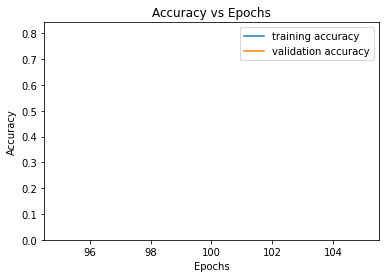

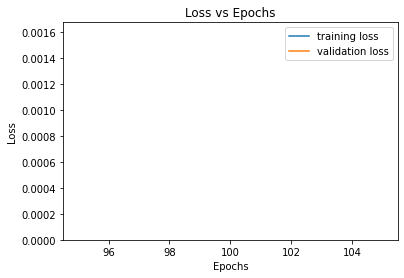

  0%|          | 0/780 [00:00<?, ?it/s]

[102] train loss: 0.00074 train accu: 0.838300 valid loss: 0.001670 valid accu: 0.718228


  0%|          | 0/780 [00:00<?, ?it/s]

[103] train loss: 0.00072 train accu: 0.839418 valid loss: 0.001603 valid accu: 0.720132


  0%|          | 1/780 [00:00<01:26,  9.00it/s]

[104] train loss: 0.00072 train accu: 0.840154 valid loss: 0.001613 valid accu: 0.721160


  0%|          | 0/780 [00:00<?, ?it/s]

[105] train loss: 0.00071 train accu: 0.840746 valid loss: 0.001607 valid accu: 0.723867


100%|██████████| 780/780 [01:20<00:00,  9.69it/s]


[106] train loss: 0.00071 train accu: 0.841423 valid loss: 0.001630 valid accu: 0.722112


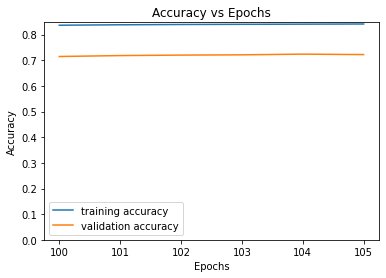

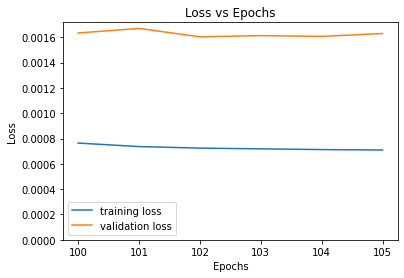

  0%|          | 1/780 [00:00<01:19,  9.83it/s]

[107] train loss: 0.00071 train accu: 0.841984 valid loss: 0.001630 valid accu: 0.722989


  0%|          | 1/780 [00:00<01:25,  9.12it/s]

[108] train loss: 0.00070 train accu: 0.842500 valid loss: 0.001583 valid accu: 0.723616


  0%|          | 1/780 [00:00<01:20,  9.64it/s]

[109] train loss: 0.00070 train accu: 0.843292 valid loss: 0.001578 valid accu: 0.724869


  0%|          | 1/780 [00:00<01:19,  9.81it/s]

[110] train loss: 0.00070 train accu: 0.843939 valid loss: 0.001579 valid accu: 0.724568


100%|██████████| 780/780 [01:16<00:00, 10.26it/s]


[111] train loss: 0.00069 train accu: 0.844711 valid loss: 0.001575 valid accu: 0.727526


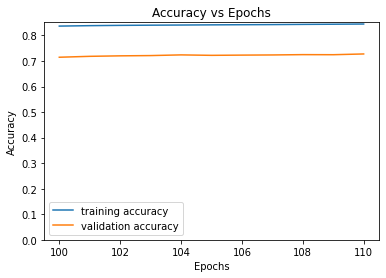

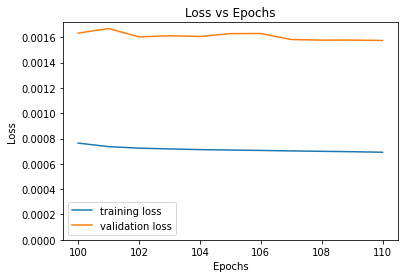

  0%|          | 1/780 [00:00<01:19,  9.81it/s]

[112] train loss: 0.00069 train accu: 0.845593 valid loss: 0.001578 valid accu: 0.725671


  0%|          | 0/780 [00:00<?, ?it/s]

[113] train loss: 0.00069 train accu: 0.846475 valid loss: 0.001583 valid accu: 0.725320


  0%|          | 1/780 [00:00<01:18,  9.92it/s]

[114] train loss: 0.00068 train accu: 0.847307 valid loss: 0.001600 valid accu: 0.728227


  0%|          | 1/780 [00:00<01:19,  9.75it/s]

[115] train loss: 0.00068 train accu: 0.848139 valid loss: 0.001630 valid accu: 0.727551


100%|██████████| 780/780 [01:15<00:00, 10.36it/s]


[116] train loss: 0.00068 train accu: 0.848806 valid loss: 0.001556 valid accu: 0.729506


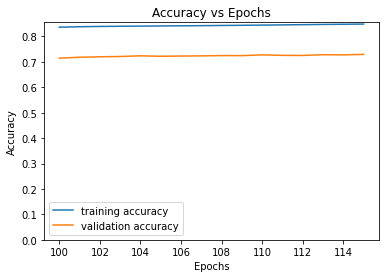

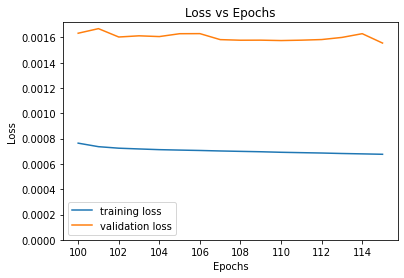

  0%|          | 1/780 [00:00<01:21,  9.53it/s]

[117] train loss: 0.00067 train accu: 0.849888 valid loss: 0.001622 valid accu: 0.729982


  0%|          | 1/780 [00:00<01:22,  9.45it/s]

[118] train loss: 0.00067 train accu: 0.850269 valid loss: 0.001570 valid accu: 0.730082


  0%|          | 1/780 [00:00<01:21,  9.53it/s]

[119] train loss: 0.00067 train accu: 0.851056 valid loss: 0.001626 valid accu: 0.728879


  0%|          | 1/780 [00:00<01:20,  9.70it/s]

[120] train loss: 0.00066 train accu: 0.851828 valid loss: 0.001568 valid accu: 0.731786


100%|██████████| 780/780 [01:16<00:00, 10.26it/s]


[121] train loss: 0.00066 train accu: 0.852715 valid loss: 0.001576 valid accu: 0.732262


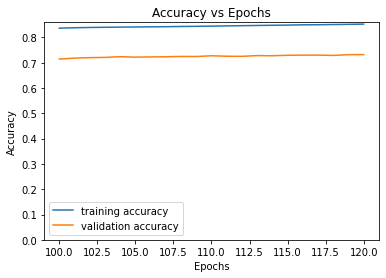

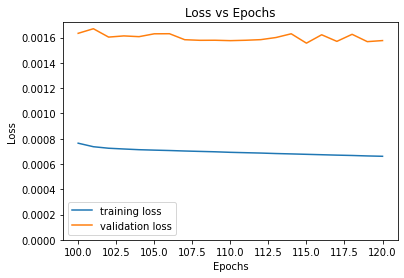

 99%|█████████▊| 770/780 [01:14<00:00, 10.41it/s]

KeyboardInterrupt: ignored

In [17]:
torch.manual_seed(0)
from tqdm import tqdm
from copy import deepcopy

# training loop
epochs = []
trainAccu = []
trainLoss = []
validAccu = []
validLoss = []

for epoch in range(100, E, 1):
  running_loss = 0.0
  running_correct = 0.0
  count = 0.0

  model.train()

  for i, data in enumerate(tqdm(train_loader, position=0)):
    # organize data
    X, y = data

    X = torch.squeeze(X,1)
    X = X.type(torch.cuda.FloatTensor)
    y = y.type(torch.cuda.FloatTensor)
    # """""""""""""""""CHANGE""""""""""""""""" IF CUDA
    
    # train
    optimizer.zero_grad()

    output = model(X)

    loss = loss_fnc(output, y)
    loss.backward()

    optimizer.step()

    # test
    running_loss += loss.item()*len(y)
    #print(output.cpu().detach().numpy().shape)
    #print(y.cpu().detach().numpy().shape)
    running_correct += accurate(output, y)
    count += len(y)
  
  # evaluate at every epoch
  trainAccu.append(running_correct/count)
  trainLoss.append(running_loss/count)
  epochs.append(epoch)

  # evaluate validation accuracy
  correct, loss = evaluate(model, loss_fnc, valid_loader)

  validAccu.append(correct)
  validLoss.append(loss)

  print("[%3d] train loss: %.5f train accu: %f valid loss: %f valid accu: %f" % (epoch+1, trainLoss[-1], trainAccu[-1], validLoss[-1], validAccu[-1]))

  # save at every epoch if needed
  torch.save(model, path + '/models/vgg_model_'+ str(epoch) +'.pt')

  if epoch % 5 == 0:
    plot_result(x=deepcopy(epochs), y=[deepcopy(trainAccu), deepcopy(validAccu)], title=["training accuracy", "validation accuracy"], x_axis="Epochs", y_axis="Accuracy", plot_title="Accuracy vs Epochs")
    plot_result(x=deepcopy(epochs), y=[deepcopy(trainLoss), deepcopy(validLoss)], title=["training loss", "validation loss"], x_axis="Epochs", y_axis="Loss", plot_title="Loss vs Epochs")

# visualize result
plot_result(x=epochs, y=[trainAccu, validAccu], title=["training accuracy", "validation accuracy"], x_axis="Epochs", y_axis="Accuracy", plot_title="Accuracy vs Epochs")
plot_result(x=epochs, y=[trainLoss, validLoss], title=["training loss", "validation loss"], x_axis="Epochs", y_axis="Loss", plot_title="Loss vs Epochs")
print("Test accuracy and loss: ", evaluate(model, loss_fnc, test_loader))

torch.save(model, path + '/models/vgg_model_LAST.pt')
